---
**CRIB SHEET RULES OF THE ROAD:**

This crib sheet is provided to support access, utilization, and plotting of UCalgary optical datasets. It is intended as a base set of code that a user may edit and manipulate to serve their own needs.  Crib sheets contains UCalgary verified and validated procedures for plotting and manipulating UCalgary ASI data for common use cases.  Use of this crib sheet does not require acknowledgment, it is freely distributed for personal scientific use. The crib sheet (or elements of the crib sheet) must not be ingested into third party libraries without written consent of the UCalgary team. Please also remember to perform due diligence on all data use.  We recommend comparison with verified data products on [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca) to ensure that any user output does not contradict operational summary plots.  Data use must be acknowledged according to the information available for each data set - please see [data.phys.ucalgary.ca](https://data.phys.ucalgary.ca).  If you encounter any issues with the data or the crib sheet, please contact the UCalgary team for support (Emma Spanswick, elspansw@ucalgary.ca). Copyright © University of Calgary.

---
## **Loading, Calibrating, and Plotting Single Channel ASI Data**
---

### **Datasets**

In a digital All-Sky Imager (ASI), an optical system (fisheye lens, filters, etc.) projects an image of the full ('2$\pi$ sky') onto the plane of a detector (CCDs, CMOS, or other). For a single 'capture', the output is an image, with each pixel corresponding to an azimuth and elevation. Data numbers within the image convey information about the brightness of the sky in the respective directions. That information might be simply related to brightness in a narrow wavelength band (e.g., REGO, TREx Blueline, TREx NIR, a NASCAM channel, etc.), or related in a more complex way to brightness across broad ranges of wavelengths (e.g., THEMIS ASI, TREx RGB).

Datasets from UCalgary geospace remote sensing projects can be found at [https://data.phys.ucalgary.ca/](https://data.phys.ucalgary.ca/). This crib sheet pertains to single channel systems:
- THEMIS ASI
- REGO
- TREx NIR
- TREx Blueline
- NORSTAR NASCAM

</br>

### **Crib Sheet Summary**
The code and supporting documentation in this file outlines the basics of working with our single-channel ASI data, specifically outlining
- Loading data
- Displaying single images
- Generating a movie
- Using image data to create keograms and ewograms
- Applying dark frame corrections to image data
- Applying flat field and radiometric calibrations to image data


</br>

---

</br>


### **Setup**

To run everything properly in Google Colab, we will mount the Google Drive folder directly into our notebook, to eliminate the need to download data. We will also install any necessary packages. Normally, this would be done in your Python environment, and files could easily be downloaded locally.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

# Change this to match the location of the UCalgary_ASI_data folder in your drive
data_dir = "/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/"

Mounted at /content/drive


In [ ]:
!python -m pip install themis-imager-readfile rego-imager-readfile trex-imager-readfile nascam-imager-readfile matplotlib scipy tqdm

In [ ]:
# Before doing anything, one must install the readfile associated with the dataset they are interested in. In this case, we import the
# THEMIS, REGO, TREx, and NASCAM readfiles for completeness, although one may opt to install only what is necessary.
#
# We will also require maplotlib, numpy, scipy, and opencv, so they are imported as well.

import themis_imager_readfile
import rego_imager_readfile
import trex_imager_readfile
import nascam_imager_readfile
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pprint
import glob
from tqdm import tqdm

In [ ]:
# First, verify that your drive has been properly mounted and the data location is properly referenced
print(os.listdir(data_dir))

['themis', 'rego', 'trex']


### **Reading Data**

In [ ]:
# To begin, let's retrieve a single minute's worth of REGO data, specifically 2021/11/04 03:20 UTC, at Gillam, MB, Canada.
# Note: In general, UCalgary ASI data is stored in one minute files. A file contains 'stacked' images each with its own metadata.
#       Depending on the imaging cadence there will be more or less images in the same file.
# Again, for the purposes of this notebook, we will be pulling from our Google Drive folder, but normally one may opt to
# download data directly to a local computer.

image_path = os.path.join(data_dir, 'rego', 'stream0', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_0621_gill_rego-652_6300.pgm.gz')

# Now lets read this file in, using the corresponding readfile
img, meta, problematic_files = rego_imager_readfile.read(image_path)

In [ ]:
# The first return value of the readfile, in this case 'img', contains the actual image data for the file passed as an argument, stored as a NumPy array.
# For a single 1-minute datafile, this NumPy array will contain some number of images - n the case of REGO, which has an imaging cadence of 3 seconds,
# a single file will usually contain 20 images.

# For a single channel image, the first two dimensions will give you the size of an actual image, whereas the last will tell you the
# number of images/frames.
print("Type of 'img' variable:", type(img))
print("Dimensions of 'img' variable:", img.shape)
print("Image dimensions: %d x %d" % (img.shape[0], img.shape[1]))
print("Number of images: %d" % (img.shape[-1]))

Type of 'img' variable: <class 'numpy.ndarray'>
Dimensions of 'img' variable: (512, 512, 20)
Image dimensions: 512 x 512
Number of images: 20


*Note: The last dimension of an image data array will **always** tell you how many images it contains.*

In [ ]:
# The second return value of the readfile, in this case 'meta', contains metadata pertaining directly to the image data. For a 1-minute
# file, the metadata will be returned as a list containing the same number of elements as the number of images contained in the file,
# usually 20 for REGO. Each list element will give a dictionary, containing metadata pertaining to the image array of the corresponding index.

print("Type of 'meta' variable:", type(meta))
print("Length of 'meta' variable:", len(meta), "\n")

# For example, one can obtain information about the first frame as follows.
print("First image Metadata:")
first_frame_meta = meta[0]
pprint.pprint(first_frame_meta)

Type of 'meta' variable: <class 'list'>
Length of 'meta' variable: 20 

First image Metadata:
{'Bright Light Status': 'DARK (550)',
 'CCD type': 'Andor E2V CCD42-40',
 'CCD xbinned': '4',
 'CCD xsize': '2048 pixels',
 'CCD ybinned': '4',
 'CCD ysize': '2048 pixels',
 'Camera Model': 'Andor DZ936N-#BV',
 'Camera Serial Number': '15652',
 'Computer name': 'gill-rego',
 'Conf file set CCD temperature': '-65 (+- 5C)',
 'Current CCD temperature': '-64C',
 'Current HS Speed': '3.0 MHz',
 'Digitemp Camera': '16.75 C',
 'Exposure Options': 'WIDTH=512 HEIGHT=512 XBIN=4 YBIN=4 MSEC=2000.00',
 'Exposure plus readout': '2002.0000 ms',
 'Filter Serial Number': '123',
 'Geographic latitude': '56.376723',
 'Geographic longitude': '-94.643664',
 'High Capacity Toggle': '0',
 'Image readout start': '2023-02-24 06:21:02.000520 UTC',
 'Image request start': '2023-02-24 06:21:00.000000 UTC',
 'Imager unique ID': 'rego-652',
 'Last Known Shutter State': 'AUTO',
 'Lens Serial Number': '123',
 'Mode sequence

---

### **Plotting Single Images**

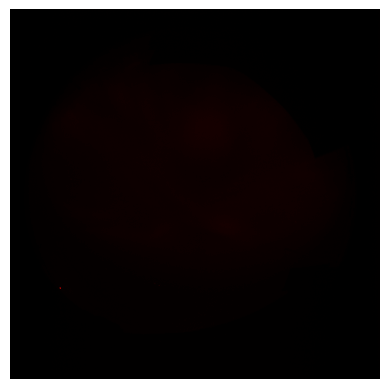

In [ ]:
# Now that 1 minute of data has been loaded in, we can plot a single image.

# *** Important note about image orientation. Although we do our best to make sure instruments are aligned as the
# readfiles expect, there are times for some imagers for which images will appear backwards when read in using the
# readfile. There is much one can to do validate the orientation of an image, for example, watching the bahavior
# of celestial objects in the imager FOV to determine cardinal directions. In this case REGO is actually
# flipped horizontally, so we fix that simply by flipping any image data we read over the vertical axis:
oriented_img = np.flip(img, axis=1)

# A single image can be obtained by slicing the image array - let's plot the first image
first_frame_img = oriented_img[:,:,0]

# We will also want the metadata that corresponds to this image.
first_frame_meta = meta[0]

# Now, simply use matplotlib to display the image array.
plt.imshow(first_frame_img, cmap='gist_heat')
plt.axis('off')
plt.show()

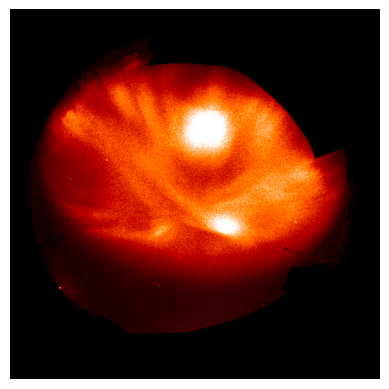

In [ ]:
# Notice, this image is quite dark. This is because in general, auroral phenomena will not use the full dynamic range of of the detector.
# Depending on the type of camera, or the phenomena you are interested in, you may wish to scale the data differently.
# We can manually scale the brightness up for plotting purposes, using the following function.

def scale_image(data, cmin=0, cmax=65535, low=0, high=65535):
    if high > 65535:
        raise ValueError("`high` should be less than or equal to 65535.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    else:
        cmin = float(cmin)
    if cmax is None:
        cmax = data.max()
    else:
        cmax = float(cmax)

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(np.uint16)

# Now, let's scale the image
scale_min = 400
scale_max = 1100
scaled_first_frame_img = scale_image(first_frame_img, cmin=scale_min, cmax=scale_max)

# and then replot the image
plt.imshow(scaled_first_frame_img, cmap='gist_heat')
plt.axis('off')
plt.show()

# *** Note, depending on the imager and the type of activity in the FOV, you will need to play around
#     with the scaling floor and ceiling in order to achieve the desired result.

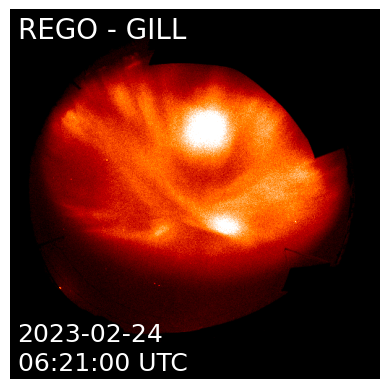

In [ ]:
# Last, it is often useful to overplot some information about the image itself. This
# can be done easily using the image's accompanying metadata:
imager = first_frame_meta["Project unique ID"]
site = first_frame_meta["Site unique ID"]
timestamp = first_frame_meta["Image request start"]
date_string = timestamp[0:10]
time_string = timestamp[11:19]

# Now, let's replot the scaled image, this time overplotting our newly obtained
# metadata, to obtain our final product:
plt.imshow(scaled_first_frame_img, cmap='gist_heat')
plt.axis('off')
plt.text(10, 40, imager.upper()+' - '+site.upper(), color='white', fontsize=20)
plt.text(10, 460, date_string, color='white', fontsize=18)
plt.text(10, 500, time_string+' UTC', color='white', fontsize=18)
plt.show()

---

### **Generate a Movie**

In [ ]:
# Now, with the ability to display single image data arrays, one can generate
# a time series movie of the ASI's data.

# Let's generate a movie with a high temporal resolution, generating a frame for
# every 3 seconds of data (same cadence that REGO images at), for 10 minutes of data.

# First, we must obtain this time period's data. It should be sorted so all frames are in the correct order
filename_list = sorted(glob.glob(os.path.join(data_dir, 'rego', 'stream0', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_061*_gill_rego-652_6300.pgm.gz')))
pprint.pprint(filename_list)


['/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0610_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0611_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0612_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0613_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0614_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0615_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024/UCalgary_ASI_data/rego/stream0/2023/02/24/gill_rego-652/ut06/20230224_0616_gill_rego-652_6300.pgm.gz',
 '/content/drive/MyDrive/DASP_2024

In [ ]:
# A common way to generate a movie in Python is to first save all of the frames
# as individual images, and then string them together into a movie using the
# method of choice. We'll start by iteratively plotting the image data in
# matplotlib, and saving each one as a .png file:

# The readfiles have an optional keyword 'workers', which allows one to manually select the
# number of processing cores utilized in multiprocessing. Setting this parameter to os.cpu_count()
# simply maximizes efficiency, using all of your computers cores.
img_flipped, meta, problematic_files = rego_imager_readfile.read(filename_list, workers=os.cpu_count())
img = np.flip(img_flipped, axis=1)

# We'll store the frames in this directory:
if not os.path.exists("rego_movie_frames"):
    os.mkdir("rego_movie_frames")

# We will want to overlay some information about each image when plotting. There a couple things that we
# can obtain right away, as they will not change with time, which we can grab from the first image's meta:
imager = meta[0]["Project unique ID"]
site = meta[0]["Site unique ID"]
first_timestamp = meta[0]["Image request start"]
date_string = first_timestamp[0:10]

n_imgs = img.shape[-1]
for i in tqdm(range(0,n_imgs), desc="Processing image frames", ncols=100):
    # Index into the img array to obtain this iteration's 2-D image array, scale it, and grab the corresponding meta
    frame = scale_image(img[:,:,i], cmin=400, cmax=1200)
    frame_meta = meta[i]

    # The metadata timestamp will change for each iteration, so we need to update it in each loop
    timestamp = frame_meta["Image request start"]
    time_string = timestamp[11:19]

    # Plot each frame using matplotlib
    plt.imshow(frame, cmap='gist_heat')
    plt.axis('off')
    plt.text(10, 40, imager.upper()+' - '+site.upper(), color='white', fontsize=20)
    plt.text(10, 460, date_string, color='white', fontsize=18)
    plt.text(10, 500, time_string+' UTC', color='white', fontsize=18)

    # Save each frame as a .png, in the directory we previously created
    plt.savefig("rego_movie_frames/frame"+f'{i:03d}'+".png", bbox_inches='tight', pad_inches = 0)
    plt.close()

# Now, the frames should be stored as .png files in the corresponding directory

Processing image frames: 100%|████████████████████████████████████| 200/200 [00:35<00:00,  5.59it/s]


In [ ]:
# All that is left to do now, is combine the images into a movie. There are many
# different packages in Python that allow one to do this, here, we will use opencv

# First we will create a list containing all of the images. As we read in each image
# we will delete the file locally since we no longer need it.
frame_list = []
for i in range(0, n_imgs):
    f = "rego_movie_frames/frame"+f'{i:03d}'+".png"
    frame = cv2.imread(f)
    frame_list.append(frame)

    # Again, cleaning workspace
    os.remove(f)
os.rmdir('rego_movie_frames')

# Before we initialize the video output, we require the size of the image frames. Since
# all of the frames are the same dimensions, we obtain them from the first frame:
width, height, n_channels = frame_list[0].shape

# Now we can initialize the video object, using the parameters of our choosing. Note
# that 'fourcc' is the tag for the codec that will be used for video compression.
movie_filename = 'MOVIE_20230224_gill_rego.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 20
frame_size = (height, width)
movie = cv2.VideoWriter(movie_filename, fourcc, fps, frame_size)

# Now, all that is left to do is write the frames to the movie object and release it
for i in range(0, n_imgs):
    movie.write(frame_list[i])
movie.release()

# The movie should now be saved - you should be able to open and view it to
# verify that everything worked properly. (Should be saved in /content directory)

---

### **Create and Display Keograms and Ewograms**

In [ ]:
# Keograms are a useful data product that can be generated from ASI image data. A keogram is created by stacking
# slices of the middle column (a N-S slice for the orientation of the UCalgary imagers) of pixels from ASI images
# over a period of time. The below code walks through the creation of a 1 hour keogram created from REGO data,
# for 2023/02/24 UT06 at Gillam, MB, Canada.

# This time, we grab a full hour's worth of data
filename_list = sorted(glob.glob(os.path.join(data_dir, 'rego', 'stream0', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_06*_gill_rego-652_6300.pgm.gz')))

# Now that we have an hours worth of data, we can read it in using the corresponding readfile.
img_flipped, meta, problematic_files = rego_imager_readfile.read(filename_list, workers=os.cpu_count())
img = np.flip(img_flipped, axis=1)


# Notice that the img and meta variables will now contain data for the full 1-hour period, and thus
# hold much more than 20 images.
print("Image dimensions: %d x %d" % (img.shape[0], img.shape[1]))
print("Number of images: %d" % (img.shape[2]))
print("Length of 'meta' variable:", len(meta), "\n")

Image dimensions: 512 x 512
Number of images: 1200
Length of 'meta' variable: 1200 



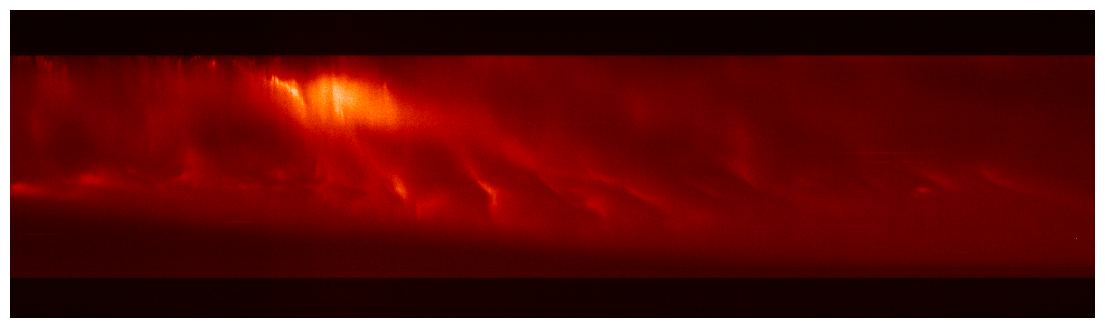

In [ ]:
# To create a keogram from the data, we will need to iterate through each individual image,
# and take a slice of the middle column of pixels. Then we will need to add these slices together
# from left to right (so that time increases to the right).

# To begin, we can define an empty NumPy array that will be filled in with the keogram data. It's height
# will be the same as that of a single image, and the width will be determined by the number of images,
# given that we take a single column slice from each.
n_rows = img.shape[0]
n_imgs = img.shape[-1]
keogram = np.empty([n_rows, n_imgs])

# It will also be useful to create a list of the timestamps for each slice (from the metadata) to use as an axis.
time_string_list = list()

# Now, we can iterate through each image within the hour, and slice the middle column, whose
# index is determined by the width of a single image:
middle_column_idx = int((img.shape[1])/2 - 1)
for img_idx in range(0,n_imgs):

    # For each iteration, we slice into 'img' to obtain a single image
    # frame, and then slice into that to obtain the center column:
    frame = img[:,:,img_idx]
    frame_middle_slice = frame[:,middle_column_idx]

    # Then, we simply insert each image slice into the corresponding location in the keogram
    keogram[:,img_idx] = frame_middle_slice

    # Lastly, we update the list of time strings with that from the current iteration's metadata
    iter_meta = meta[img_idx]
    timestamp = iter_meta["Image request start"]
    time_string = timestamp[11:16]
    time_string_list.append(time_string)

# Once all images slices have been stacked into an array, we can simply plot it to show the keogram
plt.figure(figsize=(14,4))
plt.imshow(keogram, cmap='gist_heat', aspect='auto')
plt.axis('off')
plt.show()

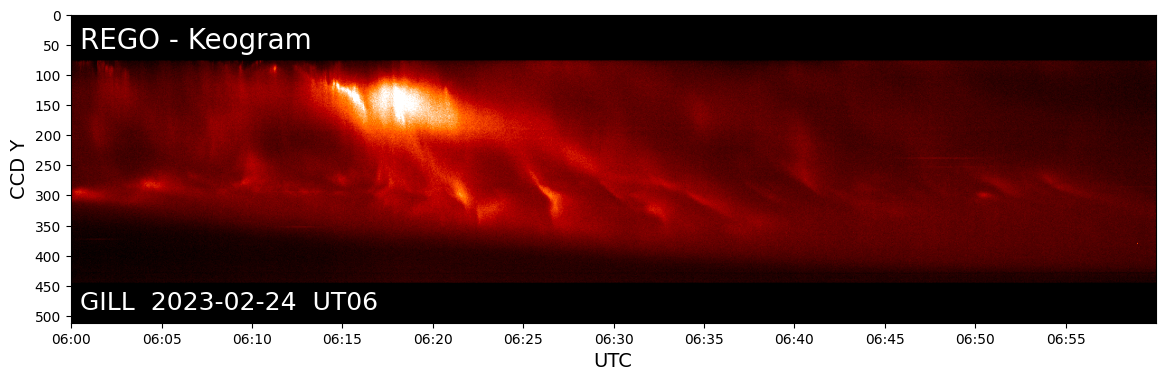

In [ ]:
# Similar to as was done for a single image, we can scale the keogram up as desired, using the bytescale function
scaled_keogram = scale_image(keogram, cmin=400, cmax=1300)

# We can also overplot some additional information about the keogram, which is easily obtainable from our metadata.
# These particular metadata fields will not change across the hour, so we can pull them from the first element of
# the full metadata_list:
imager = meta[0]["Project unique ID"]
site = meta[0]["Site unique ID"]
first_timestamp = meta[0]["Image request start"]
date_string = first_timestamp[0:10]
hour_string = first_timestamp[11:13]

# Now, we can replot the scaled image, with some additional information on top. We can also use
# the list of time strings we created as the horizontal axis:
plt.figure(figsize=(14,4))
plt.imshow(scaled_keogram, cmap='gist_heat', aspect='auto')
plt.text(10, 56, imager.upper()+' - Keogram', color='white', fontsize=20)
plt.text(10, 490, site.upper()+'  '+date_string+'  UT'+hour_string, color='white', fontsize=18)

# Generating the axes
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.yticks(np.arange(0,n_rows, 50), np.arange(0,n_rows, 50))
plt.xlabel("UTC", fontsize=14)
plt.ylabel("CCD Y", fontsize=14)
plt.show()

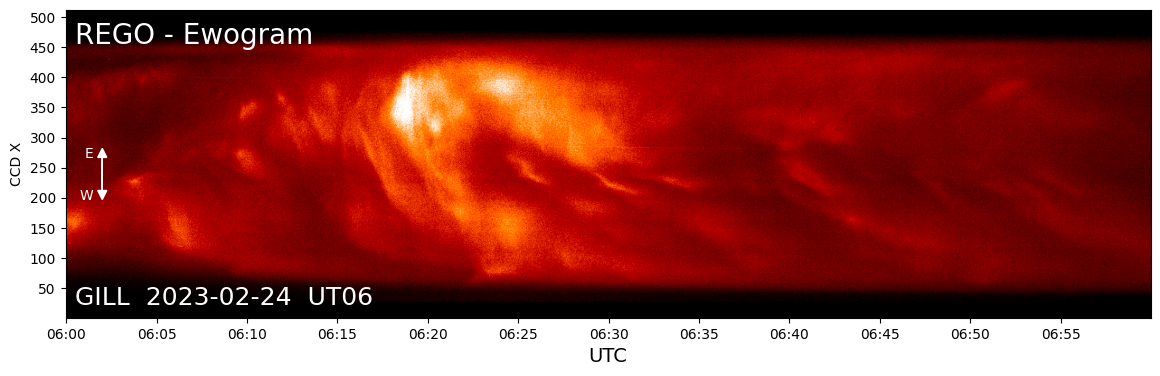

In [ ]:
# Ewograms, which are analogous to keograms, but composed of horizontal/longitudinal slices of the ASI FOV, can be generated
# using a nearly identical process.

# Here, it is important to note that the height of the ewogram is determined instead by the width of a single ASI image. Although
# this has no effect for the REGO dataset, other datasets do indeed produce images whose dimensions are not square, so it is
# important to be mindful.
n_columns = img.shape[1]
n_imgs = img.shape[-1]
ewogram = np.empty([n_columns, n_imgs])
time_string_list = list()

# This time, we will use the index of the middle row, as opposed to the middle column.
middle_row_idx = int( (img.shape[0])/2 - 1)
for img_idx in range(0,n_imgs):

    # For each iteration, we slice into 'img' to obtain a single image
    # frame, and then slice into that to obtain the center row:
    frame = img[:,:,img_idx]
    frame_middle_slice = frame[middle_row_idx,:]

    # *** This is an important step, although it may not be necessary for all cases. One must be careful in how
    #     slices are oriented. Say we wanted our ewogram to be oriented so that the bottom corresponds to western
    #     longitudes, and vice versa. If we insert the above slice directly into the ewogram array as is, this will
    #     not be the case. Consider, the first column of a row would correspond to the westernmost longitude, and
    #     when we insert that into the ewogram, it will appear at the top (first row). This will become more apparent
    #     if someone requires georeferencing, as is often the case, but it is an important point to be weary of as to
    #     not pose a risk to the integrity of your data products. In this case, we simply flip the slice.
    frame_middle_slice = np.flip(frame_middle_slice)

    # Now. we can insert this slice as the current iteration's column, and update the time string list
    ewogram[:,img_idx] = frame_middle_slice
    iter_meta = meta[img_idx]
    timestamp = iter_meta["Image request start"]
    time_string = timestamp[11:16]
    time_string_list.append(time_string)

# Scaling the ewogram
scaled_ewogram = scale_image(ewogram, cmin=400, cmax=1100)

# Obtain metadata for plotting
imager = meta[0]["Project unique ID"]
site = meta[0]["Site unique ID"]
first_timestamp = meta[0]["Image request start"]
date_string = first_timestamp[0:10]
hour_string = first_timestamp[11:13]

# Plotting the ewogram as usual
plt.figure(figsize=(14,4))
plt.imshow(scaled_ewogram, cmap='gist_heat', aspect='auto')
plt.text(10, 56, imager.upper()+' - Ewogram', color='white', fontsize=20)
plt.text(10, 490, site.upper()+'  '+date_string+'  UT'+hour_string, color='white', fontsize=18)
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.yticks(np.arange(n_columns, 0, -50), np.arange(0, n_columns, 50))
plt.ylabel("CCD X")
plt.xlabel("UTC", fontsize=14)

# In this case, it is useful to add a compass to the plot, as to not confuse viewers regarding orientation
plt.arrow(40, 250, 0, 50, color='white', head_width=10)
plt.arrow(40, 295, 0, -50, color='white', head_width=10)
plt.text(20, 245, "E", color='white')
plt.text(15, 315, "W", color='white')
plt.show()

---

### **Applying Dark Frame Corrections to Images**


In [ ]:
# For some optical system**, one may use the unexposed portion of the CCD to estimate dark counts, which essentially
# measure the total noise sources that are internal to the system. A typical way to do this
# is to take the average of the 5x5 array of pixels in the bottom corner of the image.

#  ** this only works for detectors that have a uniform noise floor. This is the case for
#     REGO, NASCAM, NIR, and THEMIS, but it is NOT the case for TREx-Blueline. Please see
#     dedicated crib sheet (coming soon) for Blueline corrections.

# Taking the first image of the same UT03 hour at Gillam, we can use array slicing to
# compute the dark counts
single_img = img[:,:,0]
bottom_row_idx = int((single_img.shape[0]) - 1)

# Using array indexing, we can take a slice of the bottom corner 5 x 5 array of pixels,
# and take the average to find the dark counts. It may be useful to check the shape
# of the array to be averaged, as a sanity check.
dark_array = single_img[bottom_row_idx-4:, 0:5]
print("Dark array dimensions: %d x %d" % (dark_array.shape[0], dark_array.shape[1]))
dark_counts = np.mean(dark_array)
print("Dark counts = %f" % (dark_counts))

Dark array dimensions: 5 x 5
Dark counts = 294.960000


Image datatype: uint16
Converted image datatype: int32
Final image datatype: uint16


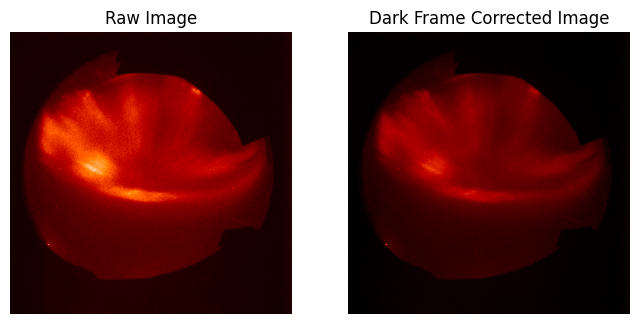

In [ ]:
# Now that we have a method for computing the dark counts, we can apply the
# correction to the image in question, by simply subtracting the dark counts
# from the entire image.

# First, it is important to note that as it stands, the image array datatype is an unsigned
# 16-bit integer. This will cause problems, as pixels which have a value lower than that
# of the dark counts will not become negative, and instead blow up to be on the order of 2^16.
original_dtype=single_img.dtype
print("Image datatype:", original_dtype)

# To avoid these issues, it is easiest to convert the array to a different datatype, such as
# a signed integer, for the time being.
signed_single_img = single_img.astype(np.int32)
print("Converted image datatype:", signed_single_img.dtype)

# Now, one can subtract the dark counts from the entire image:
dark_corrected_img = signed_single_img - int(dark_counts)

# The pixel value floor is of course zero, so we replace any negative values with zero
dark_corrected_img[np.where(dark_corrected_img < 0)] = 0

# And convert back to unsigned integer type for consistency
dark_corrected_img = dark_corrected_img.astype(original_dtype)
print("Final image datatype:", dark_corrected_img.dtype)

# At this point, the dark correction has been applied to the image. As a sanity check, plot the
# two images scaled using the same floor and ceiling:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.set_title("Raw Image")
ax1.imshow(scale_image(single_img, cmin=0, cmax=1000), cmap='gist_heat')
ax1.axis('off')
ax2.set_title("Dark Frame Corrected Image")
ax2.imshow(scale_image(dark_corrected_img, cmin=0, cmax=1000), cmap='gist_heat')
ax2.axis('off')
plt.show()

In [ ]:
# It can be useful to monitor the dark counts for an imager over the course of an
# imaging period. If an instrument is functioning normally, the dark counts will be
# stable throughout the period.

# We can plot the dark counts as a function of time, and then overplot the zenith counts
# which will give us an idea of the luminosity directly overhead, in order to make sure
# that the imager was functioning as expected. We'll use the same hour of data that we
# constructed the above keogram and ewogram with, which is still stored in the img variable.

# To begin, let's first determine the indices we need. For the dark counts,
# we once again want the bottom corner 5x5 array:
bottom_row_idx = int((img.shape[0]) - 1)

# For the zenith count, we want the center 5x5 array of the CCD:
middle_row_idx = int((img.shape[0])/2 - 1)
middle_column_idx = int((img.shape[1])/2 - 1)

# To index into the center 5x5 array, we will take advantage of array indexing using the
# center pixel indices. Let's test to make sure the dimensions are right:
test_center_array = img[middle_row_idx-2:middle_row_idx+3, middle_column_idx-2:middle_column_idx+3]

print("Centre Array Slice Dimensions: %d x %d" % (test_center_array.shape[0], test_center_array.shape[1]))

Centre Array Slice Dimensions: 5 x 5


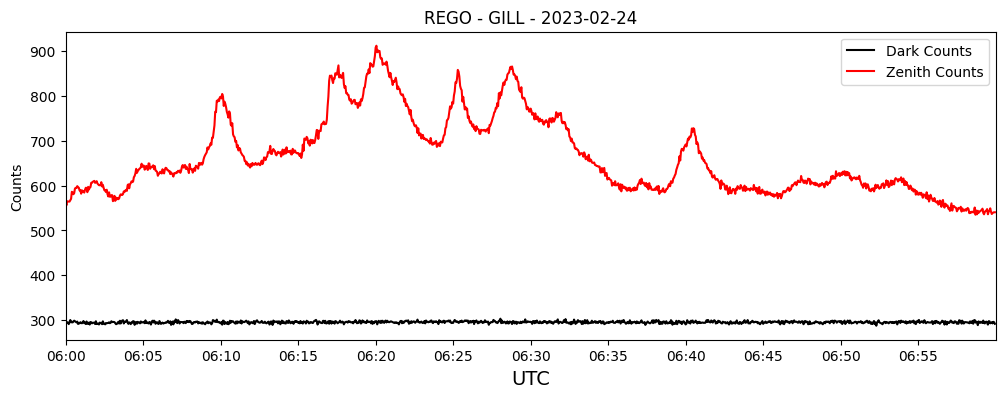

In [ ]:
# Now that we know where to grab our samples from, we just need to iterate
# through all the images and compute the dark and zenith counts for each.
dark_counts_list = []
zenith_counts_list = []
for img_idx in range(0, n_imgs):
    dark_counts = np.mean(img[bottom_row_idx-4:, 0:5, img_idx])
    zenith_counts = np.mean(img[middle_row_idx-2:middle_row_idx+3, middle_column_idx-2:middle_column_idx+3, img_idx])

    dark_counts_list.append(dark_counts)
    zenith_counts_list.append(zenith_counts)

# Now, we can simply plot the lists to see any variation over the hour:
plt.figure(figsize=(12,4))
plt.plot(dark_counts_list, color='black', label="Dark Counts")
plt.plot(zenith_counts_list, color='red', label="Zenith Counts")
plt.xlim(0,n_imgs)
plt.legend()
plt.title(imager.upper()+' - '+site.upper()+' - '+ date_string)
plt.xticks(np.arange(0,n_imgs, 100), time_string_list[::100])
plt.ylabel("Counts")
plt.xlabel("UTC", fontsize=14)
plt.show()

# We should see that the dark counts are essentially constant throughout the imaging period
# whereas the zenith counts will spike up and down with auroral activity, as expected.

---
### **Radiometric Calibration**

In [ ]:
# When working with narrow band image data such as REGO, one may perform a radiometric calibration
# in order to convert the data to physical units (Rayleighs). To do so, one must first perform
# a flat-field calibration, using calibration files found on the data portal, that allow calibration
# based on inherent properties of the optics of an imaging device.

# Grab a single image to calibrate
image_path = os.path.join(data_dir, 'rego', 'stream0', '2023', '02', '24', 'gill_rego-652', 'ut06', '20230224_0621_gill_rego-652_6300.pgm.gz')


# One can see in both the filename, as well as the metadata for this image file, that
# there is a 3-digit number associated with this particular imager. ('gill_rego-652')
# This number is a device specific identifier corresponding to the device (physical detector) that captured
# that image data.

# When loading in calibration files, one must use the correct calibration for the particular
# device that took the image. In our case, we need the calibration file that was generated
# for REGO-652 (see 'flatfield_15652' in filename)

# The flatfield files are generated in IDL and stored as IDL .sav files, so one must first
# convert the flatfield variable into a NumPy array.
flatfield_path = os.path.join(data_dir, 'rego', 'calibration', 'REGO_flatfield_15652_20141102-+_v01.sav')

# One also requires a second calibration file, which will contain a linear scaling factor, in units
# of Rayleighs per (data number * seconds), used to convert to physical units. These are located in
# the same directory, titled Rayleighs, and also include a device ID:
rayleighs_path = os.path.join(data_dir, 'rego', 'calibration', 'REGO_Rayleighs_15652_20141102-+_v01.sav')

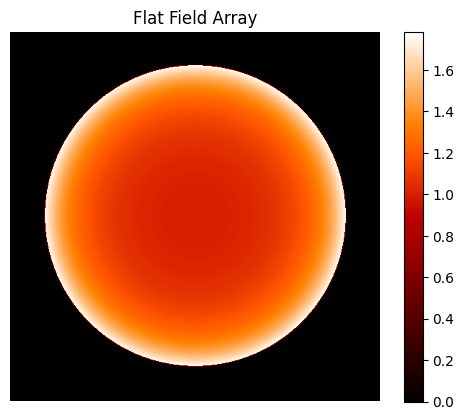

In [ ]:
# Now, since the calibration files are generated in IDL and saved as IDL .sav
# files, one must first convert the contents to Python friendly objects, which can
# be done using SciPy as follows:
device_id = '652'

flatfield_arr = scipy.io.readsav(flatfield_path)["flat_field_multiplier_15"+device_id]
rayleighs_per_dns = scipy.io.readsav(rayleighs_path)["rper_dnpersecond_15"+device_id]

# Let's also read in the image and clean our workspace, remember this REGO image is flipped
img_flipped, meta, problematic_files = rego_imager_readfile.read(image_path)
img = np.flip(img_flipped[:,:,0], axis=1)
meta = meta[0]

# Plot the flatfield array
plt.imshow(flatfield_arr, cmap='gist_heat')
plt.axis('off')
plt.colorbar()
plt.title("Flat Field Array")
plt.show()

# The flat field array is essentially a multiplicative array to be applied to the image;
# one can see that at low elevation angles, this factor is higher, which is expected.

Now, to complete the full calibration process, we must complete three
steps, in order:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 1. Dark Frame Correction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 2. Flat Field Correction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 3. Calibration to Rayleighs

In [ ]:
# Let's first apply the dark frame correction using the methodology outlined
# earlier in this crib sheet:

bottom_row_idx = int((single_img.shape[0]) - 1)
dark_array = single_img[bottom_row_idx-4:, 0:5]
dark_counts = np.mean(dark_array)

# Avoid errors with dtypes
original_dtype=single_img.dtype
signed_single_img = single_img.astype(np.int32)

# Apply dark frame subtraction and cast back to original dtype
dark_corrected_img = signed_single_img - int(dark_counts)
dark_corrected_img[np.where(dark_corrected_img < 0)] = 0
dark_corrected_img = dark_corrected_img.astype(original_dtype)

In [ ]:
# Now, let's apply the flat field calibration, by doing an element-wise
# multiplication between the image and flat field arrays

flatfield_calibrated_img = dark_corrected_img * flatfield_arr

Exposure Time: 2.002000 s


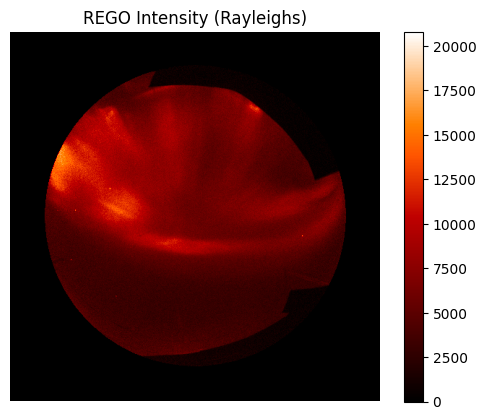

In [ ]:
# Now, the final step is to complete the radiometric calibration, which converts
# the pixel values from data numbers to physical units of Rayleighs.

# As mentioned, the radiometric conversion factor has units of Rayleighs per (data number * seconds),
# so in order to convert from data number to Rayleighs, we also need the exposure time in seconds:
exposure_millisecs = float(meta['Exposure plus readout'].split(' ')[0])
exposure_secs = exposure_millisecs / 1000.
print("Exposure Time: %f s" % exposure_secs)

# Now, we can perform the radiometric calibration, taking the product between the flat field
# calibrated image array, the radiometric conversion factor, and the exposure time:
rego_rayleighs = flatfield_calibrated_img * rayleighs_per_dns * exposure_secs

# Plot the radiometric calibrated image in Rayleighs
plt.imshow(rego_rayleighs, cmap='gist_heat')
plt.axis('off')
plt.title("REGO Intensity (Rayleighs)")
cbar = plt.colorbar()
plt.show()

**Note:**  
This plot is a bit dark... we can scale it, but ***make sure you realize what this is actually doing:***  
We can put a max value of, say, 10000 Rayleighs on the array, but we MUST account for that in the colorbar.  
By applying a scaling ceiling to the data, it means that any image pixel with a maximum value could be  
actually be greater than that ceiling, which physically, is important to realize.

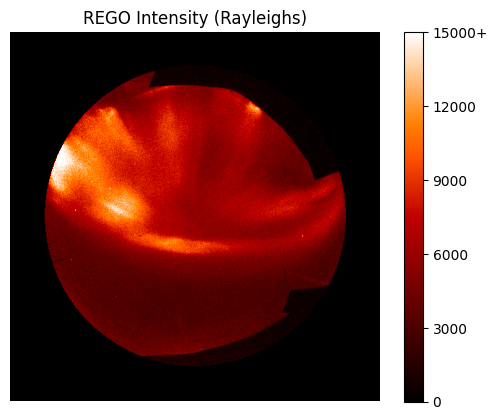

In [ ]:
# Apply a scaling ceiling of 10000 R

rayleighs_max = 15000
colormap_max = 255
rego_rayleighs_scaled = scale_image(rego_rayleighs, cmin=0, cmax=rayleighs_max, high=255)
plt.imshow(rego_rayleighs_scaled, cmap='gist_heat', vmin=0, vmax=colormap_max)
plt.axis('off')
plt.title("REGO Intensity (Rayleighs)")

# Create a colorbar, in Rayleighs, that accounts for the scaling limit we applied
cbar_ticks = [float(colormap_max)/5.*j for j in range(0,6)]
cbar_ticknames = [str(int(rayleighs_max/5)*j) for j in range(0,6)]

# Any pixels with the max Rayleigh value could be greater than it, so we include the plus sign
cbar_ticknames[-1] += '+'
cbar = plt.colorbar(ticks = cbar_ticks)
cbar.ax.set_yticklabels(cbar_ticknames)
plt.show()

# By doing this, we are losing some information. For any pixel with values greater than
# or equal to 10,000, we can no longer know it's actual intensity, only that it is >= 10000 R.

**Remember, this method of radiometric calibration is valid <u>only</u> for narrow-band detectors.**  It also assumes a detector with a linear response (which is true for REGO, NIR, NASCAM, and Blue).
